<a href="https://colab.research.google.com/github/macedoestevaof/clustering_geodata/blob/main/DBSCAN_Clustering_on_Geographic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import and Loading

In [1]:
pip install cartopy

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle, geodesic
from shapely.geometry import MultiPoint

# File paths for the Amazon delivery dataset and the Indian Cities database
pathDelivery = '/content/drive/MyDrive/Portfólio/Rede delivery/delivery.csv' # Data from: https://www.kaggle.com/datasets/sujalsuthar/amazon-delivery-dataset/
pathCities = '/content/drive/MyDrive/Portfólio/Rede delivery/Indian_Cities.csv' # Data from: https://www.kaggle.com/datasets/zed9941/top-500-indian-cities

# Load delivery data into a DataFrame
dfDelivery = pd.read_csv(pathDelivery)

# Consider only geospatial information
dfDelivery = dfDelivery.loc[:,['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude']]

# Load city information into a DataFrame
dfCities = pd.read_csv(pathCities)

# Consider city, state, population and geospatial information
dfCities = dfCities.loc[:,['name_of_city',	'state_name',	'population_total', 'location']]

# Get the coordinates of each city
dfCities['location'] = dfCities['location'].apply(lambda x: tuple(x.replace(' ', '').split(',')))

# Visualizing Raw Data on the Map

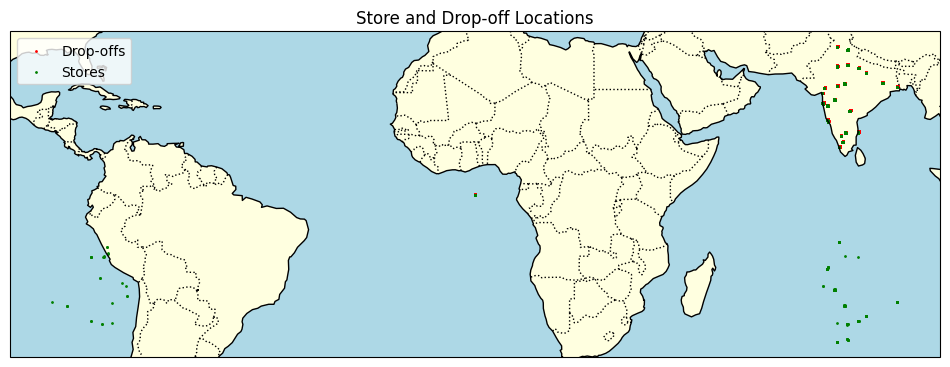

In [3]:
# Create a figure with PlateCarree projection (simple latitude-longitude map)
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features: coastlines, land, ocean, borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Add title and legend
plt.title('Store and Drop-off Locations')
plt.legend(loc='upper left')

# Show the map
plt.show()

# Geospatial Data Preprocessing

In [4]:
# Filter out records with invalid coordinates (latitude equal to zero)
dfDelivery = dfDelivery[~(dfDelivery['Store_Latitude'] == 0)]

# Correct coordinates that fall in the ocean by flipping negative values
dfDelivery.loc[dfDelivery['Store_Latitude'] <=0, 'Store_Latitude'] = dfDelivery.loc[dfDelivery['Store_Latitude'] <=0, 'Store_Latitude'] * (-1.0)
dfDelivery.loc[dfDelivery['Store_Longitude'] <=0, 'Store_Longitude'] = dfDelivery.loc[dfDelivery['Store_Longitude'] <=0, 'Store_Longitude'] * (-1.0)


# Visualizing Processed Data on the Map

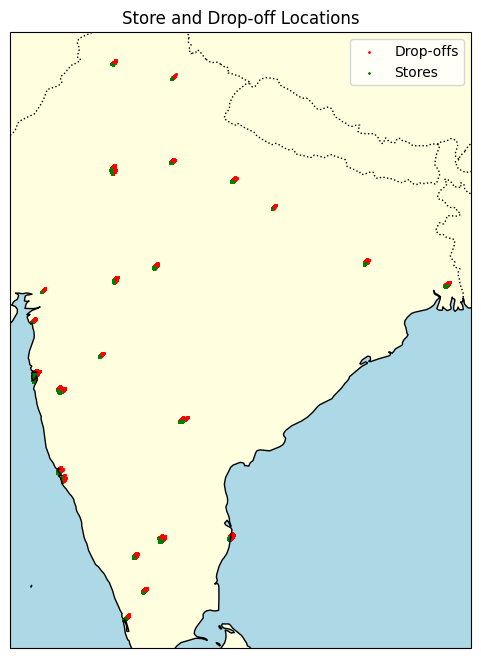

In [5]:
# Create a figure with PlateCarree projection (simple latitude-longitude map)
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features: coastlines, land, ocean, borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Add title and legend
plt.title('Store and Drop-off Locations')
plt.legend(loc='upper right')

# Show the map
plt.show()


There are more than 20 clusters across the Indian territory.
1. Next, a clustering algorithm will be applied to identify groups of locations with similar geographic proximity.
2. After that, we will attempt to determine the cities corresponding to each location.
3. Finally, we will classify the flow type into the following categories: intramunicipal, intermunicipal, and interstate.

# Preparing Coordinate Data

In [6]:
# Extract store coordinates and remove duplicate latitude–longitude pairs
dfCoordStore = dfDelivery[['Store_Latitude', 'Store_Longitude']]
dfCoordStore = dfCoordStore.drop_duplicates(ignore_index=True)

# Extract drop-off coordinates and remove duplicate latitude–longitude pairs
dfCoordDrop = dfDelivery[['Drop_Latitude', 'Drop_Longitude']]
dfCoordDrop = dfCoordDrop.drop_duplicates(ignore_index=True)

# Rename columns in both DataFrames to a unified format
dfCoordStore = dfCoordStore.rename(columns={'Store_Latitude': 'Latitude','Store_Longitude': 'Longitude'})
dfCoordDrop = dfCoordDrop.rename(columns={'Drop_Latitude': 'Latitude','Drop_Longitude': 'Longitude'})

# Concatenate store and drop-off coordinate sets into a single DataFrame
dfCoords = pd.concat([dfCoordStore, dfCoordDrop], ignore_index=True)

# Convert coordinates to a NumPy array for further processing
coords = dfCoords.to_numpy()

#  Clustering with BSDCAN Algorithm

In [7]:
# Radius of the Earth in kilometers, used to convert distance to radians
kms_per_radian = 6371.0088

# Define neighborhood size for DBSCAN
#epsilon = 3.5 / kms_per_radian
epsilon = 10 / kms_per_radian

# Apply DBSCAN clustering using the Haversine distance metric (coordinates provided in radians) and Ball Tree algorithm, that can efficiently find neighbors on the sphere
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

# Extract cluster labels assigned to each coordinate pair
cluster_labels = db.labels_

# Count the number of unique clusters
num_clusters = len(set(cluster_labels))

# Group coordinate points by cluster into a Pandas Series for further analysis
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

# Display total number of detected clusters
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 24


The number of clusters aligns with expectations.

# Observing the Clusterization Results

In [8]:
clusters

,0
0,"[[22.745049, 75.892471], [22.74806, 75.8934], ..."
1,"[[12.913041, 77.683237], [12.914264, 77.6784],..."
2,"[[11.003669, 76.976494], [11.022477, 76.995667..."
3,"[[12.972793, 80.249982], [12.986047, 80.218114..."
4,"[[17.431668, 78.408321], [17.433809, 78.386744..."
5,"[[23.369746, 85.33982], [23.357804, 85.325146]..."
6,"[[12.352058, 76.60665], [12.311072, 76.654878]..."
7,"[[30.327968, 78.046106], [30.372202, 78.077151..."
8,"[[10.003064, 76.307589], [10.035573, 76.336958..."
9,"[[18.56245, 73.916619], [18.592718, 73.773572]..."


# Calculating the Centermost Point of Each Cluster

In [9]:
# Function to find the point in a cluster closest to the geometric centroid
def getCentermostPoint(cluster):
    # Compute the centroid of the cluster
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)

    # Find the point in the cluster closest to the centroid
    centermostPoint = min(cluster, key=lambda point: great_circle(point, centroid).m)

    return tuple(centermostPoint)

# Apply the function to each cluster
centermost_points = clusters.map(getCentermostPoint)

# Display DataFrame
centermost_points

,0
0,"(22.794648, 75.944377)"
1,"(13.013298, 77.694293)"
2,"(11.063681, 77.035525)"
3,"(13.094347, 80.297221)"
4,"(17.491668, 78.468321)"
5,"(23.419746, 85.38982)"
6,"(12.383225, 76.690028)"
7,"(30.407968, 78.126106)"
8,"(10.053064, 76.357589)"
9,"(18.610963, 73.908972)"


# Mapping Centermost Points to Cluster IDs

In [10]:
# Generate cluster IDs based on the number of centermost points
cluster_ids = range(len(centermost_points))

# Create the DataFrame combining centermost points with cluster IDs
dfClusters = pd.DataFrame({
    'Center': centermost_points,
    'Cluster': cluster_ids
})

# Display DataFrame
dfClusters

,Center,Cluster
0,"(22.794648, 75.944377)",0
1,"(13.013298, 77.694293)",1
2,"(11.063681, 77.035525)",2
3,"(13.094347, 80.297221)",3
4,"(17.491668, 78.468321)",4
5,"(23.419746, 85.38982)",5
6,"(12.383225, 76.690028)",6
7,"(30.407968, 78.126106)",7
8,"(10.053064, 76.357589)",8
9,"(18.610963, 73.908972)",9


# Mapping Cities Related to the Nearest Centermost Points of Each Cluster

In [11]:
# Function to Find the Nearest City and State
def findCityState(tuplaCoord):
  dfCities['Distance'] = dfCities.apply(
      lambda row: geodesic(
          (row['location'][0], row['location'][1]),
           (tuplaCoord[0], tuplaCoord[1])
           ).km,
      axis=1)

  # Find the row with the minimum distance
  nearest_row = dfCities.loc[dfCities['Distance'].idxmin()]

  # Return city and state as a tuple
  return nearest_row['name_of_city'], nearest_row['state_name'], nearest_row['population_total'], float(nearest_row['location'][0]), float(nearest_row['location'][1])

# Assign City and State to Each Cluster
dfClusters[['City', 'State', 'Population', 'Latitude', 'Longitude']] = dfClusters['Center'].apply(lambda x: pd.Series(findCityState(x)))

# Display DataFrame
dfClusters

,Center,Cluster,City,State,Population,Latitude,Longitude
0,"(22.794648, 75.944377)",0,Indore,MADHYA PRADESH,1960631,22.719569,75.857726
1,"(13.013298, 77.694293)",1,Bengaluru,KARNATAKA,8425970,12.971600,77.594600
2,"(11.063681, 77.035525)",2,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832
3,"(13.094347, 80.297221)",3,Chennai,TAMIL NADU,4681087,13.082680,80.270718
4,"(17.491668, 78.468321)",4,Secunderabad,ANDHRA PRADESH,213698,17.439930,78.498274
5,"(23.419746, 85.38982)",5,Ranchi,JHARKHAND,1073440,23.344100,85.309562
6,"(12.383225, 76.690028)",6,Mysore,KARNATAKA,887446,12.295810,76.639381
7,"(30.407968, 78.126106)",7,Dehradun,UTTARAKHAND,578420,30.316495,78.032192
8,"(10.053064, 76.357589)",8,Kochi,KERALA,601574,9.931233,76.267304
9,"(18.610963, 73.908972)",9,Pune,MAHARASHTRA,3115431,18.520430,73.856744


# Visualizing Points, Clusters, and Related Cities on the Map

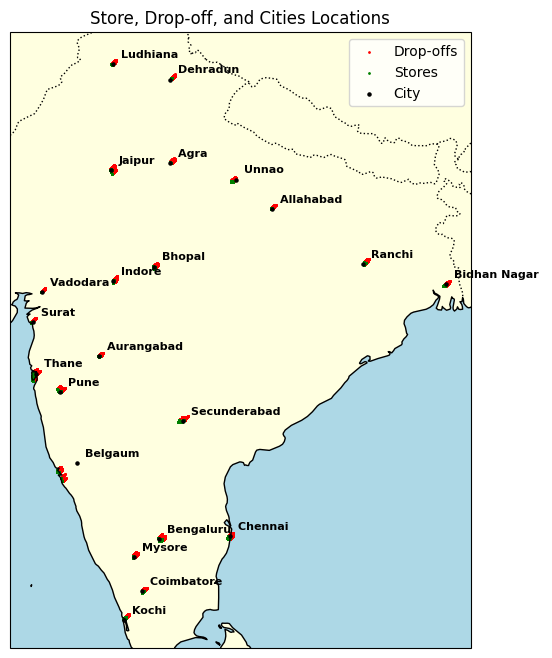

In [12]:
# Select data and remove duplicates
dfClustersCities = dfClusters[['City', 'State', 'Population',	'Latitude',	'Longitude']]
dfClustersCities = dfClustersCities.drop_duplicates(ignore_index=True)

# Map Visualization with Stores, Drop-offs, and Cluster Centers
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add basic map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightyellow')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot drop-off locations in red
ax.scatter(
    dfDelivery['Drop_Longitude'],
    dfDelivery['Drop_Latitude'],
    color='red',
    s=1,
    label='Drop-offs'
)

# Plot store locations in green
ax.scatter(
    dfDelivery['Store_Longitude'],
    dfDelivery['Store_Latitude'],
    color='green',
    s=1,
    label='Stores'
)

# Plot cluster centers in black
ax.scatter(
    dfClustersCities['Longitude'],
    dfClustersCities['Latitude'],
    color='black',
    s=5,
    label='City'
)

# Optionally, add city names as text labels
label_offset = 0.1  # degrees latitude
for idx, row in dfClustersCities.iterrows():
    ax.text(
        row['Longitude'] + 3 * label_offset,
        row['Latitude'] + 2.5 * label_offset,
        row['City'],
        fontsize=8,
        color='black',
        weight='bold'
    )

# Add title and legend
plt.title('Store, Drop-off, and Cities Locations')
plt.legend(loc='upper right')

# Show the map
plt.show()


The map visualization indicates that the **DBSCAN algorithm**, computed using Haversine distance and a Ball Tree structure, performed well in identifying clusters based on geographic coordinates. This clustering enabled the **assignment of the nearest cities** to each data point.

However, it is important to acknowledge **limitations** in the **city reference dataset**, which led to some **misclassifications**. Due to the absence of cities located closer to certain observed data points, the city of **Belgaum** was incorrectly assigned as the nearest city to a coastal region in India. This error is primarily attributable to **insufficient geographic coverage** in the **city dataset** rather than to the clustering methodology itself.

DBSCAN is an **unsupervised learning technique** that groups observations based on density and assigns proximity using distance-based criteria. While the overall clustering results were satisfactory, their accuracy remains constrained by the **quality and completeness of the geographic data**. This outcome highlights the strong dependency on high-quality, well-distributed reference data when geographic datasets are used for enrichment and spatial inference.


# Flow Classification

In [15]:
# Extract Cluster Coordinates
dfClusterMerge = pd.DataFrame({
    'Latitude': coords[:, 0].astype('float64'),
    'Longitude': coords[:, 1].astype('float64'),
    'Cluster': cluster_labels.astype('int64')
})

# Identify Store Cluster
dfDeliveryCluster = pd.merge(dfDelivery, dfClusterMerge, left_on=['Store_Latitude','Store_Longitude'], right_on=['Latitude','Longitude'], how='inner')
dfDeliveryCluster.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'Cluster': 'Cluster_Store'})

# Identify Drop Cluster
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusterMerge, left_on=['Drop_Latitude','Drop_Longitude'], right_on=['Latitude','Longitude'], how='inner')
dfDeliveryCluster.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'Cluster': 'Cluster_Drop'})

# Identify Store City
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusters, left_on=['Cluster_Store'], right_on='Cluster', how='inner')
dfDeliveryCluster.drop(['Center', 'Cluster'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'City': 'City_Store', 'Population': 'Population_Store', 'State': 'State_Store'})

# Identify Drop City
dfDeliveryCluster = pd.merge(dfDeliveryCluster, dfClusters, left_on=['Cluster_Drop'], right_on='Cluster', how='inner')
dfDeliveryCluster.drop(['Center', 'Cluster'], axis=1, inplace=True)
dfDeliveryCluster = dfDeliveryCluster.rename(columns={'City': 'City_Drop', 'Population': 'Population_Drop', 'State': 'State_Drop'})

# Remove Cluster
dfDeliveryCluster.drop(['Cluster_Store', 'Cluster_Drop'], axis=1, inplace=True)
dfDeliveryCluster

# Function to classify the type of delivery flow based on store and drop-off locations
def flowType(cityStore, stateStore, cityDrop, stateDrop):
  if stateStore != stateDrop:
    return 'Interstate'
  elif cityStore == cityDrop:
    return 'Intramunicipal'
  else:
    return 'Interstate'

# Apply the flowType function to each row of the DataFrame
dfDeliveryCluster['Flow_Type'] = dfDeliveryCluster.apply(
    lambda row: flowType(row['City_Store'], row['State_Store'], row['City_Drop'], row['State_Drop']),
      axis=1)

# Display DataFrame
dfDeliveryCluster

,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,City_Store,State_Store,Population_Store,Latitude_x,Longitude_x,City_Drop,State_Drop,Population_Drop,Latitude_y,Longitude_y,Flow_Type
0,22.745049,75.892471,22.765049,75.912471,Indore,MADHYA PRADESH,1960631,22.719569,75.857726,Indore,MADHYA PRADESH,1960631,22.719569,75.857726,Intramunicipal
1,12.913041,77.683237,13.043041,77.813237,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Intramunicipal
2,12.914264,77.678400,12.924264,77.688400,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Bengaluru,KARNATAKA,8425970,12.971600,77.594600,Intramunicipal
3,11.003669,76.976494,11.053669,77.026494,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Intramunicipal
4,12.972793,80.249982,13.012793,80.289982,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Intramunicipal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40229,23.371292,85.327872,23.481292,85.437872,Ranchi,JHARKHAND,1073440,23.344100,85.309562,Ranchi,JHARKHAND,1073440,23.344100,85.309562,Intramunicipal
40230,26.902328,75.794257,26.912328,75.804257,Jaipur,RAJASTHAN,3073350,26.912434,75.787271,Jaipur,RAJASTHAN,3073350,26.912434,75.787271,Intramunicipal
40231,13.022394,80.242439,13.052394,80.272439,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Chennai,TAMIL NADU,4681087,13.082680,80.270718,Intramunicipal
40232,11.001753,76.986241,11.041753,77.026241,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Coimbatore,TAMIL NADU,1061447,11.016844,76.955832,Intramunicipal


# Flow Type Distribution

In [16]:
# Display the count of each flow type in the DataFrame
dfDeliveryCluster['Flow_Type'].value_counts()

,count
Flow_Type,
Intramunicipal,40234


This time, we got lucky and were handed a dataset that contained **only intramunicipal flows**.  

With that, we wrap up our analysis. However, things could look different if the same algorithm were applied to another dataset with more diverse flows.

Feel free to take the code and give it a spin with your own data to explore how the classifications could change!

Last but not least, we save the enriched dataset from this study.

In [ ]:
# Saving Enriched Data
dfDeliveryCluster.to_csv('/content/drive/MyDrive/Portfólio/Rede delivery/delivery_enrich.csv')